# Data-X Project

In [247]:
import csv
import re
import numpy as np
import pandas as pd 
import seaborn as sns
import spacy
import nltk
import statsmodels.api as sm
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()
ps = nltk.PorterStemmer()
import matplotlib.pyplot as plt
from matplotlib import pyplot
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/srv/app/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


[nltk_data] Downloading package wordnet to /srv/app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
! pip install vaderSentiment

  Using cached https://files.pythonhosted.org/packages/86/9e/c53e1fc61aac5ee490a6ac5e21b1ac04e55a7c2aba647bb8411c9aadf24e/vaderSentiment-3.2.1-py2.py3-none-any.whl


## Sentiment Analysis for Bitcoin Hashtag on Twitter

### 1.Read the files into pandas dataframe 



The original data:

Tweets 1 consists of all the cryptocurrency related tweets from Oct 20 to Oct 27, 2018. 

Tweets 2 consists of all the cryptocurrency related tweets from Nov 1 to Nov 9, 2018

In [154]:
tweets1 = pd.read_csv("bitcoin.csv")[['Author', 'Text', 'Retweet_Count', 'Timestamp']]
tweets1.head()

,Author,Text,Retweet_Count,Timestamp
0,ewin74698177,RT @SolarisCoin: Take a peek @ https://t.co/W8...,49,2018-10-27 23:25:41
1,thegustians,RT @SolarisCoin: Take a peek @ https://t.co/W8...,49,2018-10-27 23:10:20
2,frg_x,RT @SolarisCoin: Take a peek @ https://t.co/W8...,49,2018-10-27 23:07:04
3,TechniCraftCZ,RT @CryptoPepes: CryptoPepes just soft launche...,93,2018-10-27 23:02:48
4,victordorofeev1,RT @SolarisCoin: Take a peek @ https://t.co/W8...,49,2018-10-27 23:01:47


In [155]:
tweets2 = pd.read_csv('bitcointweets.csv')[['Author', 'Text', 'Retweet_Count', 'Timestamp']]
tweets2.head()

,Author,Text,Retweet_Count,Timestamp
0,Sharp_or_Parish,Booooommmmmmm!\r\n\r\n4th POD HAMMER BOMB to t...,0,2018-11-09 06:13:30
1,T45Investments,5.00 GMT Update!\r\n#trading #futures #commodi...,0,2018-11-09 06:03:09
2,ArbingTool,#DASH\r\nBuy at #Koinim and sell at #YoBit. Ra...,0,2018-11-09 06:01:30
3,ArbingTool,#ETH\r\nBuy at #Bitstamp and sell at #Bittrex....,0,2018-11-09 06:01:21
4,ArbingTool,#XRP\r\nBuy at #Bitstamp and sell at #Bitfinex...,0,2018-11-09 06:01:12


### 2. Data cleaning function: 
Remove urls, mentions, punctuations and stopwords

In [8]:
class CleanText():
    
    def __init__(self, input_text):
        self.input_text = input_text
    
    def remove(self):
        remove_mention = re.sub(r'@\w+', '', self.input_text)
        remove_url = re.sub(r'http.?://[^\s]+[\s]?', '', remove_mention)
        # By compressing the underscore, the emoji is kept as one word
        remove_emoji = remove_url.replace('_','')
        remove_punctuation = re.sub('[^A-Za-z0-9_\s]', '', remove_emoji)
        lowercase = remove_punctuation.lower()
        remove_n = re.sub('[\n\r]', '', lowercase)
        remove_num = re.sub('[[:digit:]]', '', remove_n)
        
        return remove_num.replace('rt', '')

In [114]:
clean_tweet1 = []
for tweet in tweets1['Text']:
    clean_tweet1.append(CleanText(tweet).remove())
    
clean_tweets1 = tweets1.drop(['Text'], axis = 1)
clean_tweets1['Clean_Text'] = clean_tweet1
clean_tweets1.head()

clean_tweet2 = []
for tweet in tweets2['Text']:
    clean_tweet2.append(CleanText(tweet).remove())
    
clean_tweets2 = tweets2.drop(['Text'], axis = 1)
clean_tweets2['Clean_Text'] = clean_tweet2
clean_tweets2 = clean_tweets2[49:] #only selecting a one-week period: Nov 1 - 8.
clean_tweets2.head()

,Author,Retweet_Count,Timestamp,Clean_Text
49,CryptoPriceBot_,0,2018-11-08 23:59:56,btcethxrplast 648000 21278 050high 659400 2207...
50,coinok,0,2018-11-08 23:30:04,1 btc price bitstamp 640094 usd coinbase 64050...
51,pattern_crypto,0,2018-11-08 23:15:12,btc volume spike 43 coin print at 640400 btcu...
52,ArbingTool,0,2018-11-08 23:01:22,bchbuy at koineks and sell at yobit ratio 428b...
53,ArbingTool,0,2018-11-08 23:01:13,btcbuy at btcturk and sell at binance ratio 10...


### 3. Sentiment analysis

We will look at the compound score for each sentence.

In [116]:
analyzer = SentimentIntensityAnalyzer()

score1 = []
for sentence in clean_tweets1['Clean_Text']:
    score1.append(analyzer.polarity_scores(sentence))

sentiment1 = []
for each in score1:
    sentiment1.append(each['compound'])
clean_tweets1['compound'] = sentiment1

score2 = []
for sentence in clean_tweets2['Clean_Text']:
    score2.append(analyzer.polarity_scores(sentence))

sentiment2 = []
for each in score2:
    sentiment2.append(each['compound'])
clean_tweets2['compound'] = sentiment2

The threshold for positive comment is >= 0.05, for neutral comment is > - 0.05 and for negative comment is <= -0.05.

We will classify the tweets using this threshold. 

In [117]:
comment_class = []
for score in clean_tweets1['compound']:
    if score <= -0.05:
        comment_class.append('Negative')
    elif score >= 0.05:
        comment_class.append('Positive')
    else:
        comment_class.append('Neutral')
clean_tweets1['type'] = comment_class

comment_class = []
for score in clean_tweets2['compound']:
    if score <= -0.05:
        comment_class.append('Negative')
    elif score >= 0.05:
        comment_class.append('Positive')
    else:
        comment_class.append('Neutral')
clean_tweets2['type'] = comment_class

### 4. Compute length of each tweets and write both of them to csv file

In [118]:
clean_tweets1['text_len'] = [len(text) for text in clean_tweets1['Clean_Text']]
x1 = clean_tweets1[['compound', 'text_len']]
x1.to_csv('x1.csv')
clean_tweets2['text_len'] = [len(text) for text in clean_tweets2['Clean_Text']]
x2 = clean_tweets2[['compound', 'text_len']]
x2.to_csv('x2.csv')

### *Since R studio has better packages for statistical analysis, I will perform the hypothesis testing part of my analysis in R and please look at the R file for reference. 

### 5. Statistical  Facts

In [122]:
comp_mean1 = np.mean(clean_tweets1['compound'])
print('Average Compound Score, Oct 20-27: ', comp_mean1)
comp_mean2 = np.mean(clean_tweets2['compound'])
print('Average Compound Score, Nov 1-9: ', comp_mean2)
print('On average period x2 slightly more positive than the previous time period')

Average Compound Score, Oct 20-27:  0.07347113402061857
Average Compound Score, Nov 1-9:  0.258245450470641
On average period x2 slightly more positive than the previous time period


In [123]:
sd1 = np.std(clean_tweets1['compound'])
print('Standard deviation for compound score, Oct 20-27: ', sd1)
sd2 = np.std(clean_tweets2['compound'])
print('Standard deviation for compound score, Nov 1-9: ', sd2)
print('Period 2 had more spread out compound score than that in period 1')

Standard deviation for compound score, Oct 20-27:  0.23609588540442542
Standard deviation for compound score, Nov 1-9:  0.344639700863988
Period 2 had more spread out compound score than that in period 1


In [124]:
len_mean1 = np.mean(clean_tweets1['text_len'])
print('Average Tweet length, Oct 20-27: ', len_mean1)
len_mean2 = np.mean(clean_tweets2['text_len'])
print('Average Tweet length, Nov 1-9: ', len_mean2)
print('On average period 2 slightly had more lengthy tweets than the period 1 had')

Average Tweet length, Oct 20-27:  95.90500736377025
Average Tweet length, Nov 1-9:  99.8695652173913
On average period 2 slightly had more lengthy tweets than the period 1 had


In [125]:
sd_mean1 = np.std(clean_tweets1['text_len'])
print('Standard deviation for Tweet length, Oct 20-27: ', sd_mean1)
sd_mean2 = np.std(clean_tweets2['text_len'])
print('Standard deviation for Tweet length, Nov 1-9: ', sd_mean2)
print('Period 2 had more spread out Tweet length than that in period 1')

Standard deviation for Tweet length, Oct 20-27:  14.195737343513139
Standard deviation for Tweet length, Nov 1-9:  15.03912488212654
Period 2 had more spread out Tweet length than that in period 1


Just by looking at these stats, we observe that generally period 2 has more positive compound sentiment tweets and more length tweets, and the distribution of its compound sentiment score and length tweets has more variability. 

In [126]:
X1 = clean_tweets1[['Timestamp', 'compound', 'text_len']]
clean_time = []
for time in clean_tweets1['Timestamp']:
    clean_time += re.findall('[0-9]{4}\-[0-9]{2}\-[0-9]{2}', time)

X1['clean_time'] = clean_time
X1

final = []
for time in X1['clean_time']:
    final += re.findall('[0-9]{2}$', time)
X1['time'] = pd.to_numeric(final)

X2 = clean_tweets2[['Timestamp', 'compound', 'text_len']]
clean_time = []
for time in clean_tweets2['Timestamp']:
    clean_time += re.findall('[0-9]{4}\-[0-9]{2}\-[0-9]{2}', time)

X2['clean_time'] = clean_time
X2

final = []
for time in X2['clean_time']:
    final += re.findall('[0-9]{2}$', time)
X2['time'] = pd.to_numeric(final)

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

In [127]:
aggregate_X1 = X1.groupby('time').mean().reset_index()
aggregate_X1

,time,compound,text_len
0,20,0.023130,95.938356
1,21,0.026739,96.447154
2,22,0.036863,95.550898
3,23,0.022359,94.812500
4,24,0.043975,94.962963
5,25,0.066979,96.803922
6,26,0.107026,94.420765
7,27,0.216462,98.040609


In [169]:
aggregate_X2 = X2.groupby('time').mean().reset_index()
aggregate_X2.to_csv('aggregate_x2.txt')

### Analysis of average compound sentiment score and tweet length by day

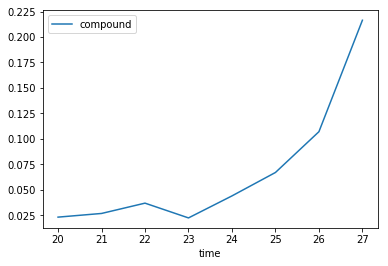

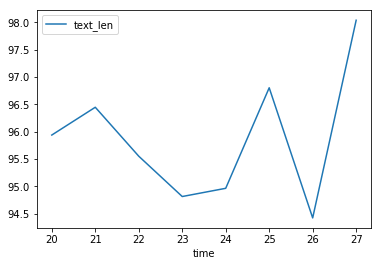

In [158]:
aggregate_X1.plot.line(x = 'time', y = 'compound') #average sentiment compound
aggregate_X1.plot.line(x = 'time', y = 'text_len') #average tweet length

Referring to the linear regression analysis on compound sentiment score and tweet length, we have the slope coefficient as 0.032, and the corresponding p value is 0.14, which is too large to be used to reject the null. In this case, we can't say anything about the relationship between compound sentiment score and tweet length from Oct 20 to 27. 

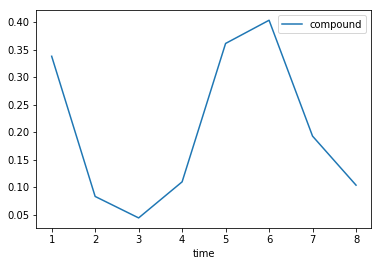

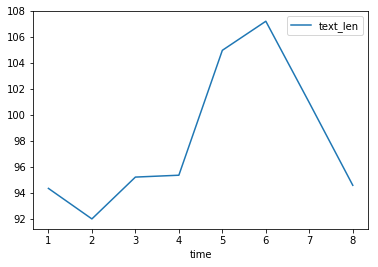

In [159]:
aggregate_X2.plot.line(x = 'time', y = 'compound') #average sentiment compound
aggregate_X2.plot.line(x = 'time', y = 'text_len') #average tweet length

According to the linear regression outcomes in R, we've found that a linear relationship can be used to describe the association between tweet length and compound sentiment score. The slope coefficient is 0.0205, the p-value is 0.011, the p-value for the F-statistic is 0.011. All of these statistics are small enough to prove that there is linearity between the length of tweets and compound sentiment score during Nov 1 and 8, that is, the more people talked about bitcoin in a single tweet is associated with the more positive the sentiment towards bitcoin.

So this leads us to ponder: what is the reason behind such linearity between tweet length and compound sentiment score? 

Was there any external events that impacted people's tweeting behavior and attitude towards bitcoin?

##### It turned out that Nov 2nd was the 10-year-old anniversary of the creation of bitcoin. 
##### So we will definitely need external data to analyze this!

Moving further, I collected the "BTC price index" data in these two periods to delve more deeply into the causation behind the linear pattern

### BTC Price Index vs. Sentiment score in Period  2

In [243]:
price_data = pd.read_csv('bitcoin_full.csv')
price_X2 = price_data[['date', 'high', 'low','opens','close','volume']][18:26]
price_X2['day'] = [8,7,6,5,4,3,2,1]
price_X2 = price_X2.sort_values('day', ascending = True)
price_X2

,date,high,low,opens,close,volume,day
25,"Nov 01, 2018",6547.14,6311.83,6318.14,6377.78,3.789400e+09,1
24,"Nov 02, 2018",6396.86,6327.38,6378.92,6388.44,4.234870e+09,2
23,"Nov 03, 2018",6400.07,6342.37,6387.24,6361.26,3.658640e+09,3
22,"Nov 04, 2018",6388.63,6294.57,6365.47,6376.13,4.390020e+09,4
21,"Nov 05, 2018",6480.59,6363.62,6363.62,6419.66,4.174800e+09,5
20,"Nov 06, 2018",6463.55,6408.16,6433.38,6461.01,4.700040e+09,6
19,"Nov 07, 2018",6552.16,6468.31,6468.50,6530.14,4.941260e+09,7
18,"Nov 08, 2018",6536.92,6438.53,6522.27,6453.72,4.665260e+09,8


Next we will plot a side by side line graph which consist of three subgraphs: average compound sentiment score of tweets in period 2, average tweet length, and the last one is one of the attributes in the 'price_X2' data frame - high, low, opens, close and volume

### High 

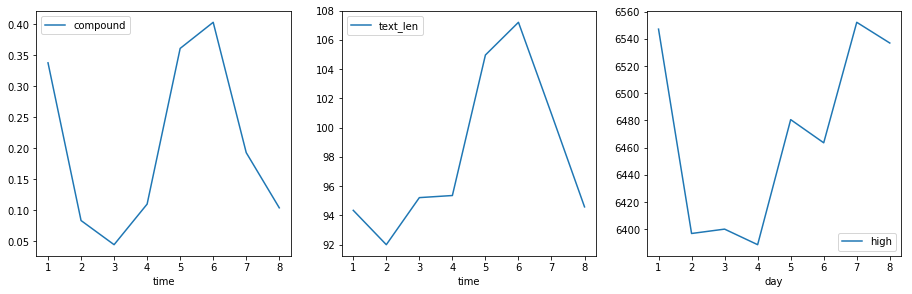

<Figure size 432x288 with 0 Axes>

In [241]:
fig, ax =plt.subplots(1,3)
fig.set_size_inches(15.5, 4.5)
aggregate_X2.plot.line(x = 'time', y = 'compound',ax=ax[0]) 
aggregate_X2.plot.line(x = 'time', y = 'text_len',ax=ax[1])
price_X2.plot.line(x = 'day', y = 'high',ax=ax[2])

plt.figure();

In [265]:
X = list(aggregate_X2['compound'])
y = list(price_X2['high'])

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     16.85
Date:                Mon, 26 Nov 2018   Prob (F-statistic):            0.00454
Time:                        21:25:18   Log-Likelihood:                -76.648
No. Observations:                   8   AIC:                             155.3
Df Residuals:                       7   BIC:                             155.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.231e+04   5433.832      4.105      0.005    9459.446    3.52e+04
==============================================================================
Omnibus:                        2.906   Durbin-Watson:                   0.932
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                0.992
Skew:                          -0.356   Prob(JB):                        0.609
Kurtosis:                       1.428   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [262]:
X = list(aggregate_X2['text_len'])
y = list(price_X2['high'])

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2596.
Date:                Mon, 26 Nov 2018   Prob (F-statistic):           2.94e-10
Time:                        21:19:00   Log-Likelihood:                -57.878
No. Observations:                   8   AIC:                             117.8
Df Residuals:                       7   BIC:                             117.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            65.7967      1.291     50.955      0.000      62.743      68.850
==============================================================================
Omnibus:                        1.541   Durbin-Watson:                   0.862
Prob(Omnibus):                  0.463   Jarque-Bera (JB):                1.000
Skew:                          -0.719   Prob(JB):                        0.606
Kurtosis:                       2.036   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Low

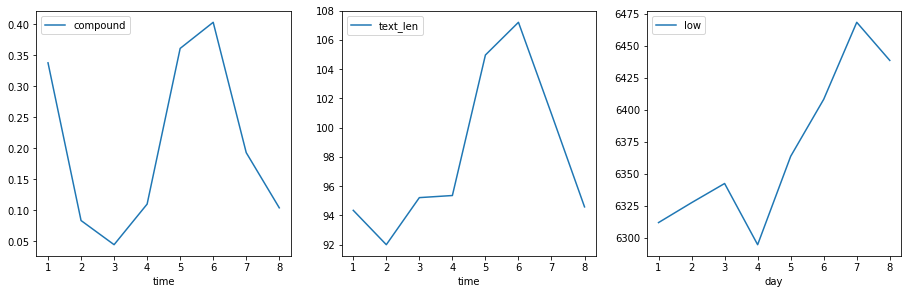

<Figure size 432x288 with 0 Axes>

In [242]:
fig, ax =plt.subplots(1,3)
fig.set_size_inches(15.5, 4.5)
aggregate_X2.plot.line(x = 'time', y = 'compound',ax=ax[0]) 
aggregate_X2.plot.line(x = 'time', y = 'text_len',ax=ax[1])
price_X2.plot.line(x = 'day', y = 'low',ax=ax[2])

plt.figure();

In [264]:
X = list(aggregate_X2['compound'])
y = list(price_X2['low'])

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     16.61
Date:                Mon, 26 Nov 2018   Prob (F-statistic):            0.00472
Time:                        21:25:09   Log-Likelihood:                -76.563
No. Observations:                   8   AIC:                             155.1
Df Residuals:                       7   BIC:                             155.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.191e+04   5376.476      4.075      0.005    9197.681    3.46e+04
==============================================================================
Omnibus:                        3.084   Durbin-Watson:                   0.936
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                1.005
Skew:                          -0.343   Prob(JB):                        0.605
Kurtosis:                       1.404   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [266]:
X = list(aggregate_X2['text_len'])
y = list(price_X2['low'])

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2835.
Date:                Mon, 26 Nov 2018   Prob (F-statistic):           2.16e-10
Time:                        21:25:33   Log-Likelihood:                -57.401
No. Observations:                   8   AIC:                             116.8
Df Residuals:                       7   BIC:                             116.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            64.7724      1.217     53.244      0.000      61.896      67.649
==============================================================================
Omnibus:                        1.570   Durbin-Watson:                   0.936
Prob(Omnibus):                  0.456   Jarque-Bera (JB):                1.016
Skew:                          -0.720   Prob(JB):                        0.602
Kurtosis:                       2.011   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Opens

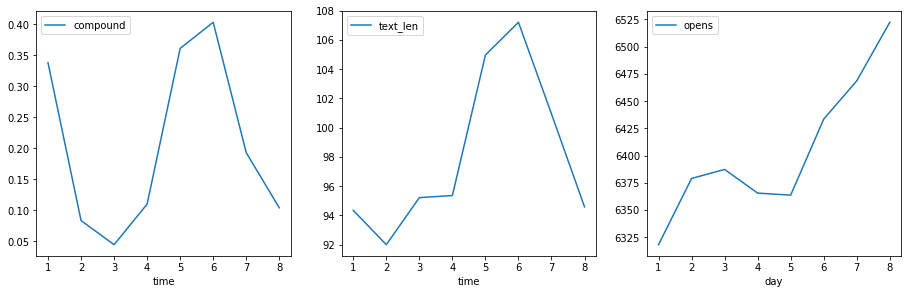

<Figure size 432x288 with 0 Axes>

In [244]:
fig, ax =plt.subplots(1,3)
fig.set_size_inches(15.5, 4.5)
aggregate_X2.plot.line(x = 'time', y = 'compound',ax=ax[0]) 
aggregate_X2.plot.line(x = 'time', y = 'text_len',ax=ax[1])
price_X2.plot.line(x = 'day', y = 'opens',ax=ax[2])

plt.figure();

In [267]:
X = list(aggregate_X2['compound'])
y = list(price_X2['opens'])

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     16.37
Date:                Mon, 26 Nov 2018   Prob (F-statistic):            0.00490
Time:                        21:26:16   Log-Likelihood:                -76.648
No. Observations:                   8   AIC:                             155.3
Df Residuals:                       7   BIC:                             155.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.198e+04   5434.174      4.046      0.005    9134.934    3.48e+04
==============================================================================
Omnibus:                        3.157   Durbin-Watson:                   0.936
Prob(Omnibus):                  0.206   Jarque-Bera (JB):                1.012
Skew:                          -0.339   Prob(JB):                        0.603
Kurtosis:                       1.395   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [268]:
X = list(aggregate_X2['text_len'])
y = list(price_X2['opens'])

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2530.
Date:                Mon, 26 Nov 2018   Prob (F-statistic):           3.21e-10
Time:                        21:27:00   Log-Likelihood:                -57.899
No. Observations:                   8   AIC:                             117.8
Df Residuals:                       7   BIC:                             117.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            65.1225      1.295     50.300      0.000      62.061      68.184
==============================================================================
Omnibus:                        1.466   Durbin-Watson:                   0.996
Prob(Omnibus):                  0.480   Jarque-Bera (JB):                0.959
Skew:                          -0.651   Prob(JB):                        0.619
Kurtosis:                       1.913   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Close

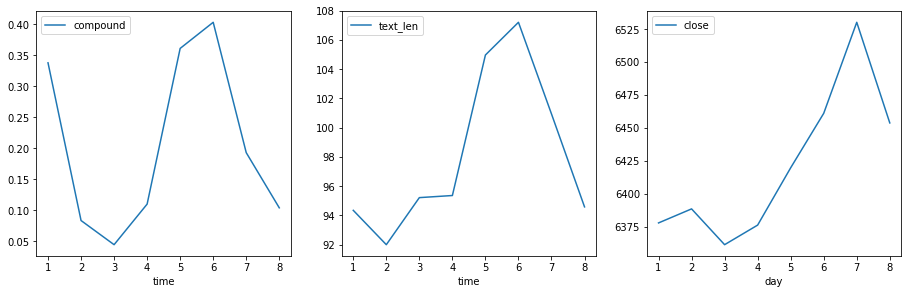

<Figure size 432x288 with 0 Axes>

In [245]:
fig, ax =plt.subplots(1,3)
fig.set_size_inches(15.5, 4.5)
aggregate_X2.plot.line(x = 'time', y = 'compound',ax=ax[0]) 
aggregate_X2.plot.line(x = 'time', y = 'text_len',ax=ax[1])
price_X2.plot.line(x = 'day', y = 'close',ax=ax[2])

plt.figure();

In [269]:
X = list(aggregate_X2['compound'])
y = list(price_X2['close'])

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     16.69
Date:                Mon, 26 Nov 2018   Prob (F-statistic):            0.00466
Time:                        21:27:45   Log-Likelihood:                -76.614
No. Observations:                   8   AIC:                             155.2
Df Residuals:                       7   BIC:                             155.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           2.21e+04   5410.641      4.085      0.005    9310.631    3.49e+04
==============================================================================
Omnibus:                        3.094   Durbin-Watson:                   0.940
Prob(Omnibus):                  0.213   Jarque-Bera (JB):                1.010
Skew:                          -0.348   Prob(JB):                        0.603
Kurtosis:                       1.404   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [270]:
X = list(aggregate_X2['text_len'])
y = list(price_X2['close'])

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2895.
Date:                Mon, 26 Nov 2018   Prob (F-statistic):           2.01e-10
Time:                        21:28:00   Log-Likelihood:                -57.382
No. Observations:                   8   AIC:                             116.8
Df Residuals:                       7   BIC:                             116.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            65.2991      1.214     53.801      0.000      62.429      68.169
==============================================================================
Omnibus:                        1.621   Durbin-Watson:                   0.978
Prob(Omnibus):                  0.445   Jarque-Bera (JB):                1.036
Skew:                          -0.744   Prob(JB):                        0.596
Kurtosis:                       2.053   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Volume

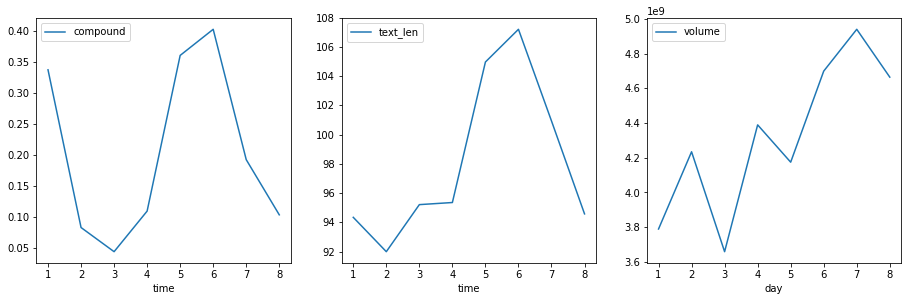

<Figure size 432x288 with 0 Axes>

In [246]:
fig, ax =plt.subplots(1,3)
fig.set_size_inches(15.5, 4.5)
aggregate_X2.plot.line(x = 'time', y = 'compound',ax=ax[0]) 
aggregate_X2.plot.line(x = 'time', y = 'text_len',ax=ax[1])
price_X2.plot.line(x = 'day', y = 'volume',ax=ax[2])

plt.figure();

In [271]:
X = list(aggregate_X2['compound'])
y = list(price_X2['volume'])

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     16.80
Date:                Mon, 26 Nov 2018   Prob (F-statistic):            0.00458
Time:                        21:28:13   Log-Likelihood:                -183.99
No. Observations:                   8   AIC:                             370.0
Df Residuals:                       7   BIC:                             370.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.495e+10   3.65e+09      4.098      0.005    6.33e+09    2.36e+10
==============================================================================
Omnibus:                        4.625   Durbin-Watson:                   1.050
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                1.261
Skew:                          -0.452   Prob(JB):                        0.532
Kurtosis:                       1.278   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [272]:
X = list(aggregate_X2['text_len'])
y = list(price_X2['volume'])

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     882.0
Date:                Mon, 26 Nov 2018   Prob (F-statistic):           1.26e-08
Time:                        21:28:54   Log-Likelihood:                -169.50
No. Observations:                   8   AIC:                             341.0
Df Residuals:                       7   BIC:                             341.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4.401e+07   1.48e+06     29.698      0.000    4.05e+07    4.75e+07
==============================================================================
Omnibus:                        1.958   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.376   Jarque-Bera (JB):                0.749
Skew:                          -0.069   Prob(JB):                        0.688
Kurtosis:                       1.508   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [274]:
print(' P>|t| are all equal to 0.05 in the above linear regression model. If we choose an alpha of 0.05, we can reject the null hypothesis and say that the coefficient is significantly different from 0')

 P>|t| are all equal to 0.05 in the above linear regression model. If we choose an alpha of 0.05, we can reject the null hypothesis and say that the coefficient is significantly different from 0
